In [22]:
%matplotlib inline
__author__ = 'thomas'

'''
In this part, we will look into how the users are using different options of the search, and how they are using it,
in which context and try to find who they are and for which need they use it.
'''

# Alright ! Let's do this
# We have csv file containing data from Ally app
# The idea will be to extract as many insights as possible
# Let's first start by importing the file


# import libraries
import numpy as np, matplotlib.pyplot as plt, matplotlib, pandas as pd, os

# Import the data file as a Pandas DataFrame
path = os.getcwd()
rq = pd.read_csv(path + '/data/route_queries.csv')

In [23]:
# Check the columns and their data types

print(rq.dtypes)

user_id                    object
query_time                 object
search_time                object
search_mode                object
search_origin_lat         float64
search_origin_lon         float64
search_destination_lat    float64
search_destination_lon    float64
dtype: object


In [24]:
# Convert dates from object to date type:

rq['query_time'] = (rq['query_time'].apply(pd.to_datetime))
rq['search_time'] = (rq['search_time'].apply(pd.to_datetime))

print(rq.dtypes)

user_id                           object
query_time                datetime64[ns]
search_time               datetime64[ns]
search_mode                       object
search_origin_lat                float64
search_origin_lon                float64
search_destination_lat           float64
search_destination_lon           float64
dtype: object


In [25]:
# Visualize 1st lines of the dataset

print(rq.head(2))
print('\n')

                            user_id          query_time         search_time  \
0  a705557d29972bc625e4918adb22fd71 2015-02-16 13:40:55 2015-02-16 13:40:00   
1  d673381dc02a48921cde830672aef3ba 2015-04-19 10:06:08 2015-04-19 10:06:00   

  search_mode  search_origin_lat  search_origin_lon  search_destination_lat  \
0   departure          50.910542           6.962613               50.941001   
1   departure          52.398180          13.049791               52.404202   

   search_destination_lon  
0                6.975166  
1               13.038500  




In [26]:
# What is the size of our sample ?
rq_size = len(rq.index)
print('Number of events: ' + str(rq_size))
print(rq.columns)  # Column names

Number of events: 100000
Index(['user_id', 'query_time', 'search_time', 'search_mode',
       'search_origin_lat', 'search_origin_lon', 'search_destination_lat',
       'search_destination_lon'],
      dtype='object')


In [27]:
# Are users searching their route in advance or at last minute ?

rq['query_to_search_time'] = rq['search_time'] - rq['query_time']
print(rq['query_to_search_time'])

0       -1 days +23:59:05
1       -1 days +23:59:52
2       -1 days +23:59:41
3       -1 days +23:59:20
4       -1 days +23:59:27
5       -1 days +23:59:25
6       -1 days +23:59:49
7       -1 days +23:59:48
8         0 days 01:13:20
9       -1 days +23:59:14
10      -1 days +23:59:26
11        0 days 00:51:02
12        0 days 00:02:49
13        0 days 02:43:38
14      -1 days +23:59:49
15      -1 days +23:59:22
16      -1 days +23:59:28
17      -1 days +23:59:03
18      -1 days +23:59:43
19      -1 days +23:59:05
20        0 days 00:14:22
21        0 days 00:30:18
22      -1 days +23:59:51
23      -1 days +23:58:59
24        0 days 00:59:32
25        1 days 18:18:12
26        0 days 00:18:10
27        0 days 03:49:45
28      -1 days +23:59:29
29        0 days 01:42:09
               ...       
99970   -1 days +23:59:17
99971   -1 days +23:59:04
99972   -1 days +23:59:09
99973     0 days 00:06:58
99974   -1 days +23:58:47
99975     2 days 08:49:34
99976   -1 days +23:59:53
99977   -1 d

In [28]:
# Negative values are due to the small delay between app opening and the actual time the user
# tap the search button. We can see that they are really small.
# They should not be considered for our use case... BUT they give us
# a very useful information: the time to complete the form !
# It's actually an indicator we could use for UX evaluation (and improvement) (we'll come back on this later!)

In [29]:
# Let's check how much time in advance the user look for a route
rq_in_advance = rq[rq['query_to_search_time'] > pd.Timedelta('0 days')]
print(rq_in_advance['query_to_search_time'].describe())

count                     29905
mean     1 days 00:22:43.617923
std      7 days 01:14:21.059081
min             0 days 00:00:01
25%             0 days 00:43:40
50%             0 days 02:59:35
75%             0 days 12:54:50
max           724 days 19:18:00
Name: query_to_search_time, dtype: object


In [30]:
print(str(len(rq_in_advance.index)) + ' events are use to check the route in advance, they represent ' +
      str(round(len(rq_in_advance.index) / rq_size * 100, 2)) + '% of our the app usage')

29905 events are use to check the route in advance, they represent 29.9% of our the app usage


In [31]:
# Looks like there are some outliers here, some people searching for long time in the future.. Doesn't look like
# a normal usage of Ally, let's limit it to 30 days in the future to exclude extreme cases.
rq_in_advance_filter = rq_in_advance[rq_in_advance['query_to_search_time'] < pd.Timedelta('30 days')]
print(rq_in_advance_filter['query_to_search_time'].describe())
rq_in_advance_filter2 = rq_in_advance[rq_in_advance['query_to_search_time'] > pd.Timedelta('30 days')]
print(rq_in_advance_filter2['query_to_search_time'].describe())

count                     29781
mean     0 days 17:06:32.825459
std      2 days 03:52:19.202079
min             0 days 00:00:01
25%             0 days 00:43:19
50%             0 days 02:58:14
75%             0 days 12:46:08
max            29 days 23:59:21
Name: query_to_search_time, dtype: object
count                        124
mean     73 days 18:19:45.959677
std      74 days 20:08:00.572751
min             30 days 00:39:28
25%      39 days 08:35:11.500000
50%             51 days 19:44:00
75%      78 days 15:01:51.250000
max            724 days 19:18:00
Name: query_to_search_time, dtype: object


In [32]:
# Let's describe the distribution of this usage in a histogram, per hour

# Let's calculate the total time in hour and trunc. The value 0 corresponds to the bucket 0-1 hour
# The value n corresponds to the bucket n-n+1 hour before departure
value_hour = np.trunc(rq_in_advance_filter['query_to_search_time'].astype('timedelta64[s]') / 3600)
time_in_advance = value_hour.value_counts(sort=False)
time_in_advance.head(10)

0    9614
1    3651
2    1692
3     987
4     685
5     531
6     580
7     698
8     907
9     935
Name: query_to_search_time, dtype: int64

In [33]:
# We probably have a lot of small value, we need to define a treshold before plotting 
print(len(time_in_advance.index))
print(len(time_in_advance[time_in_advance>20]))

422
79


In [34]:
time_in_advance_f = time_in_advance[time_in_advance>20]

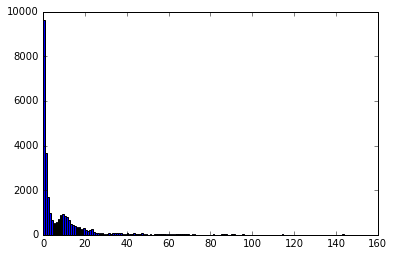

In [35]:
# Let's plot this :

plt.bar(time_in_advance_f.index,time_in_advance_f,  color="blue")
plt.show()

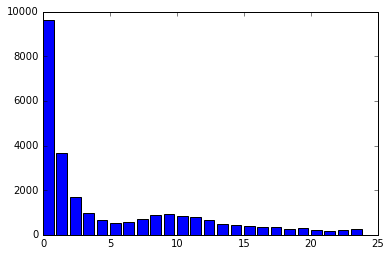

In [36]:
# With no surprise, majority of users are looking for routes in the next few hours
# There seems to be a local maximum within the first 24 hours, let's have a closer look at this:
time_in_advance24 = time_in_advance.head(24)
plt.bar(time_in_advance24.index,time_in_advance24,  color="blue")
plt.show()

In [37]:
# In percentage : 
time_in_advance24 / len(rq_in_advance.index) * 100

0     32.148470
1     12.208661
2      5.657917
3      3.300451
4      2.290587
5      1.775623
6      1.939475
7      2.334058
8      3.032938
9      3.126567
10     2.788831
11     2.671794
12     2.153486
13     1.578331
14     1.488045
15     1.384384
16     1.106838
17     1.110182
18     0.899515
19     1.013208
20     0.772446
21     0.621970
22     0.678816
23     0.902859
Name: query_to_search_time, dtype: float64

In [38]:
# 32% of searches in advance are within the next hour
# 12% between one and two hours
# 5.7 % between two and three and so on...

# There is a local maximum between 7 and 12 hours, it probably correspond to the users that are looking their 
# route in the evening for the next day or in the morning for the evening.

In [39]:
# This raison our next question, at what time is the app used ?
# In the same way we'll have a look at the time of day
# Note : I took the assumption that the times are expressed in local time everytime
# This assumption should be valid because even if the sample is coming from different cities and countries, 
# the query time should be expressed in local time, not as GMT for analysis purpose.
rq['query_time_hour'] = np.trunc((rq['query_time'] - pd.to_datetime(0)).dt.seconds / 3600)
rq['query_time_hour']
use_time_hour = rq['query_time_hour'].value_counts(sort=False)
use_time_hour

0     1589
1     1121
2     1058
3     1209
4     1890
5     3057
6     4194
7     4455
8     4637
9     4716
10    4847
11    4859
12    5155
13    5408
14    5793
15    5999
16    6196
17    5990
18    5771
19    5302
20    5477
21    5013
22    3865
23    2399
Name: query_time_hour, dtype: int64

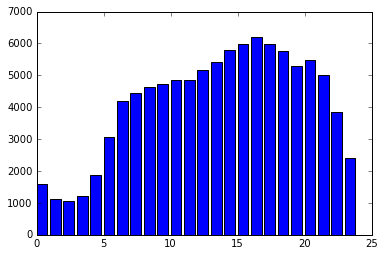

In [40]:
# Let's plot this :

plt.bar(use_time_hour.index,use_time_hour,  color="blue")
plt.show()

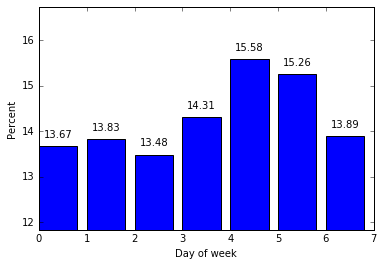

In [98]:
# As we can expect, most of the route searches are happening during "day time", between 6 and 22
# with a maximum around 17:00, end of the day for most of the business
# The usage 
# We can also have a look at the day of week, to check if the app is mostly used during week (work comuting)
# Or other the weekends (freetime, tourism...)

rq['query_time_dow'] = rq['query_time'].apply( lambda x : x.dayofweek) # Note: Monday = 0, Sun = 6
use_dow = rq['query_time_dow'].value_counts(sort=False)
use_dow_perc = np.round(use_dow/use_dow.sum()*100,2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim(use_dow_perc.mean() - 3 * use_dow_perc.std(),use_dow_perc.mean() + 3 * use_dow_perc.std())
plt.bar(use_dow_perc.index,use_dow_perc,color="blue")
plt.xlabel('Day of week')
plt.ylabel('Percent')
for i,j in zip(use_dow_perc.index,use_dow_perc):
    ax.annotate(str(j),xy=(i+0.1,j+0.2))
plt.show()

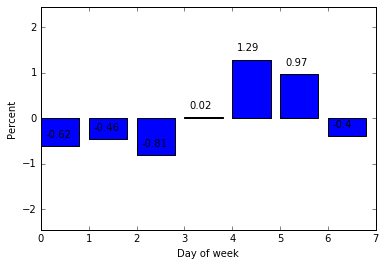

In [100]:
# The usage is quite uniform throughout the days of week:
# Let's plot the deviation from the mean:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim(0 - 3 * use_dow_perc.std(),0 + 3 * use_dow_perc.std())
plt.bar(use_dow_perc.index,use_dow_perc-round(use_dow_perc.mean(),2),color="blue")
plt.xlabel('Day of week')
plt.ylabel('Percent')
for i,j in zip(use_dow_perc.index,use_dow_perc-round(use_dow_perc.mean(),2)):
    ax.annotate(str(j),xy=(i+0.1,j+0.2))
plt.show()

In [103]:
# The variation between the days is around +/- 1% of total number of searches, it is quite constant

# There is a peak on Friday and Saturday (Thursday is also above average)
# These days are traditionnaly "party days", or at least the days where people are going out
# This creates additionnal demand for route search because people may commute to new places

# The rest of searches seems to be coming from daily comuting usage (cf. The time of usage)
# A additionnal step to understand our users would be to get more information about their profile, 
# (age, employment type...)

In [104]:
# Are the users using the app with departure datetime or arrival datetime ?
search_mode = rq_in_advance_filter['search_mode'].value_counts()
print(search_mode)

departure    20770
arrival       9011
Name: search_mode, dtype: int64


In [105]:
print(str(round(search_mode['departure'] / search_mode.sum()*100)) + '% of users are using departure (is default)')
print(str(round(search_mode['arrival'] / search_mode.sum()*100)) + '% of users are using arrival')

70.0% of users are using departure (is default)
30.0% of users are using arrival


In [106]:
rq_last_minute = rq[rq['query_to_search_time'] < pd.Timedelta('0 days')]
rq_last_minute['query_to_search_time'].describe()

count                       69955
mean     -1 days +22:55:30.824186
std        1 days 01:22:16.632744
min           -111 days +05:30:42
25%             -1 days +23:59:08
50%             -1 days +23:59:24
75%             -1 days +23:59:41
max             -1 days +23:59:59
Name: query_to_search_time, dtype: object

In [107]:
# It looks like some user managed to search for a time in the past up to 111 days..
# On average 1 hours before the actual time...
# Although this shoud not be possible on the app, it appears on the data. This could be a bug.
# EDIT: after a few tests, I managed to reproduce that bug.. :)
# However there seems to be very low number of such cases as the 25% shows.
# I will bet on wrong data and exclude them from this sample:
rq_last_minute = rq_last_minute[rq_last_minute['query_to_search_time'] > pd.Timedelta('-1 days')]
rq_last_minute['query_to_search_time'].describe()

count                       69791
mean     -1 days +23:48:06.929016
std        0 days 01:42:43.621974
min             -1 days +00:00:09
25%             -1 days +23:59:08
50%             -1 days +23:59:24
75%             -1 days +23:59:41
max             -1 days +23:59:59
Name: query_to_search_time, dtype: object

In [ ]:
# According to this data set, 75% of the users are completing the search screen in less than 1 minute, 
# even if the mean is quite big (12 mins) due to bigger values in the sample.
# This could be a KPI for UX. The goal being to lower the time on the screen of the user 
# so that he can access the results he needs quickly.